# **Spotify Song Clustering for Playlist Generation**
This project aims to cluster Spotify songs into meaningful musical groups using unsupervised learning algorithms (K-Means & Hierarchical Clustering). The resulting clusters will power playlist generation features based on musical similarity.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings
warnings.filterwarnings('ignore')

### **1. Data Preprocessing**

### Data Loading

In [2]:
df = pd.read_csv(r"C:\Users\Moved Files\Desktop\Git Projects\5. Spoftify\Archive\spotify.csv")

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
data = df
data.shape

(114000, 20)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [7]:
data.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


### Missing values and duplicates

In [8]:
data.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [9]:
data.dropna(inplace = True)
data.isnull().sum()

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [10]:
data.duplicated().sum()

450

In [11]:
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

In [12]:
data.shape

(113549, 20)

### Dropping Identifier Columns

In [13]:
cols_to_drop = df.select_dtypes(include = 'object').columns.tolist()
data.drop(cols_to_drop, axis = 1, inplace = True)
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


### Outlier Detection and Removal

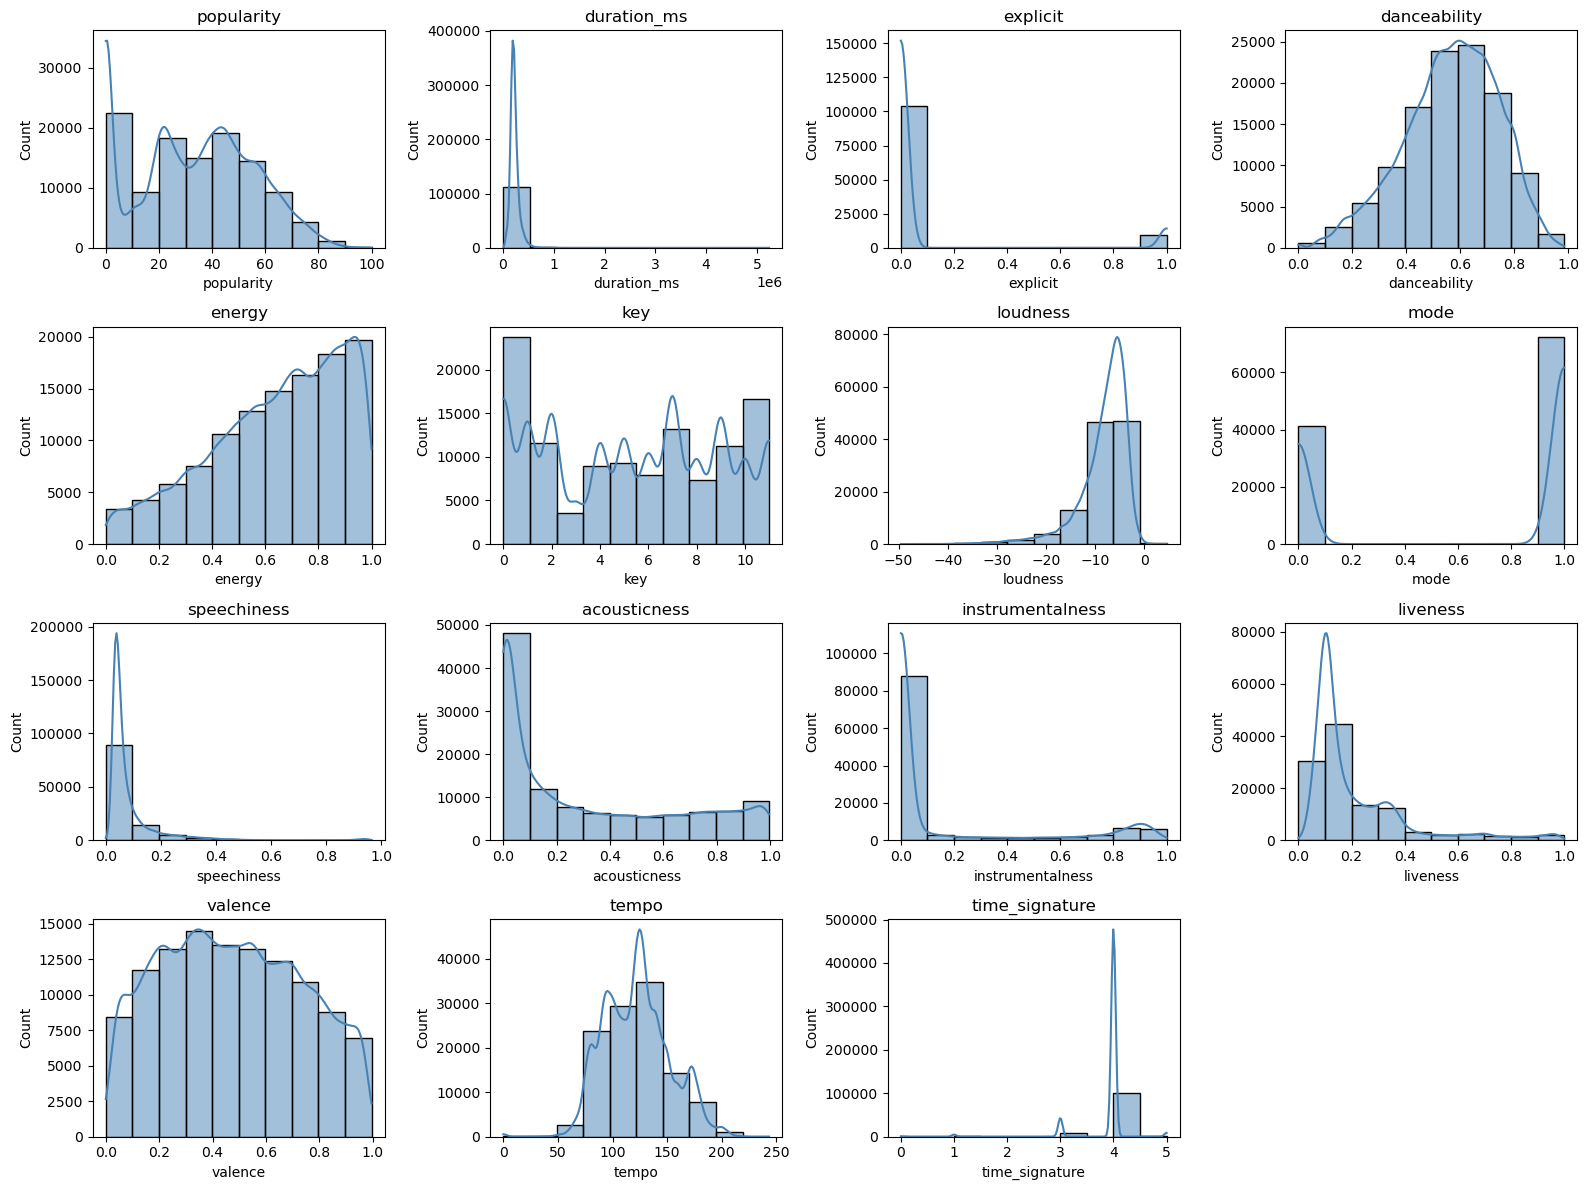

In [14]:
#Histograms (subplots) of variable distribution
numeric_cols = data.columns
plt.figure(figsize = (16,12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i + 1)
    sns.histplot (data[col], kde = True, bins = 10, color = 'steelblue')
    plt.title(col)

plt.tight_layout()
plt.show()

The pair grid displays distributions of audio features from the music dataset revealing key patterns. **Popularity** is right-skewed, with most songs having low to moderate popularity. **Duration_ms** clusters between 3 to 5 minutes, though some outliers exist. **Explicit** and **mode** are binary, with most songs being non-explicit and in a major key. **Danceability** is normally distributed around 0.6, while **energy** is left-skewed, with many high-energy songs. **Key** is fairly uniform, and **loudness** centers around -10 dB. **Speechiness**, **acousticness**, and **instrumentalness** are all highly right-skewed, indicating most songs have low values for these features. **Liveness** suggests mostly studio tracks, though some are live. **Valence** is evenly spread, **tempo** is multimodal with peaks around 90, 120, and 150 BPM, and **time_signature** is mostly 4/4. Overall, the dataset reflects that most songs are upbeat, non-explicit, studio-recorded, and follow common musical patterns.


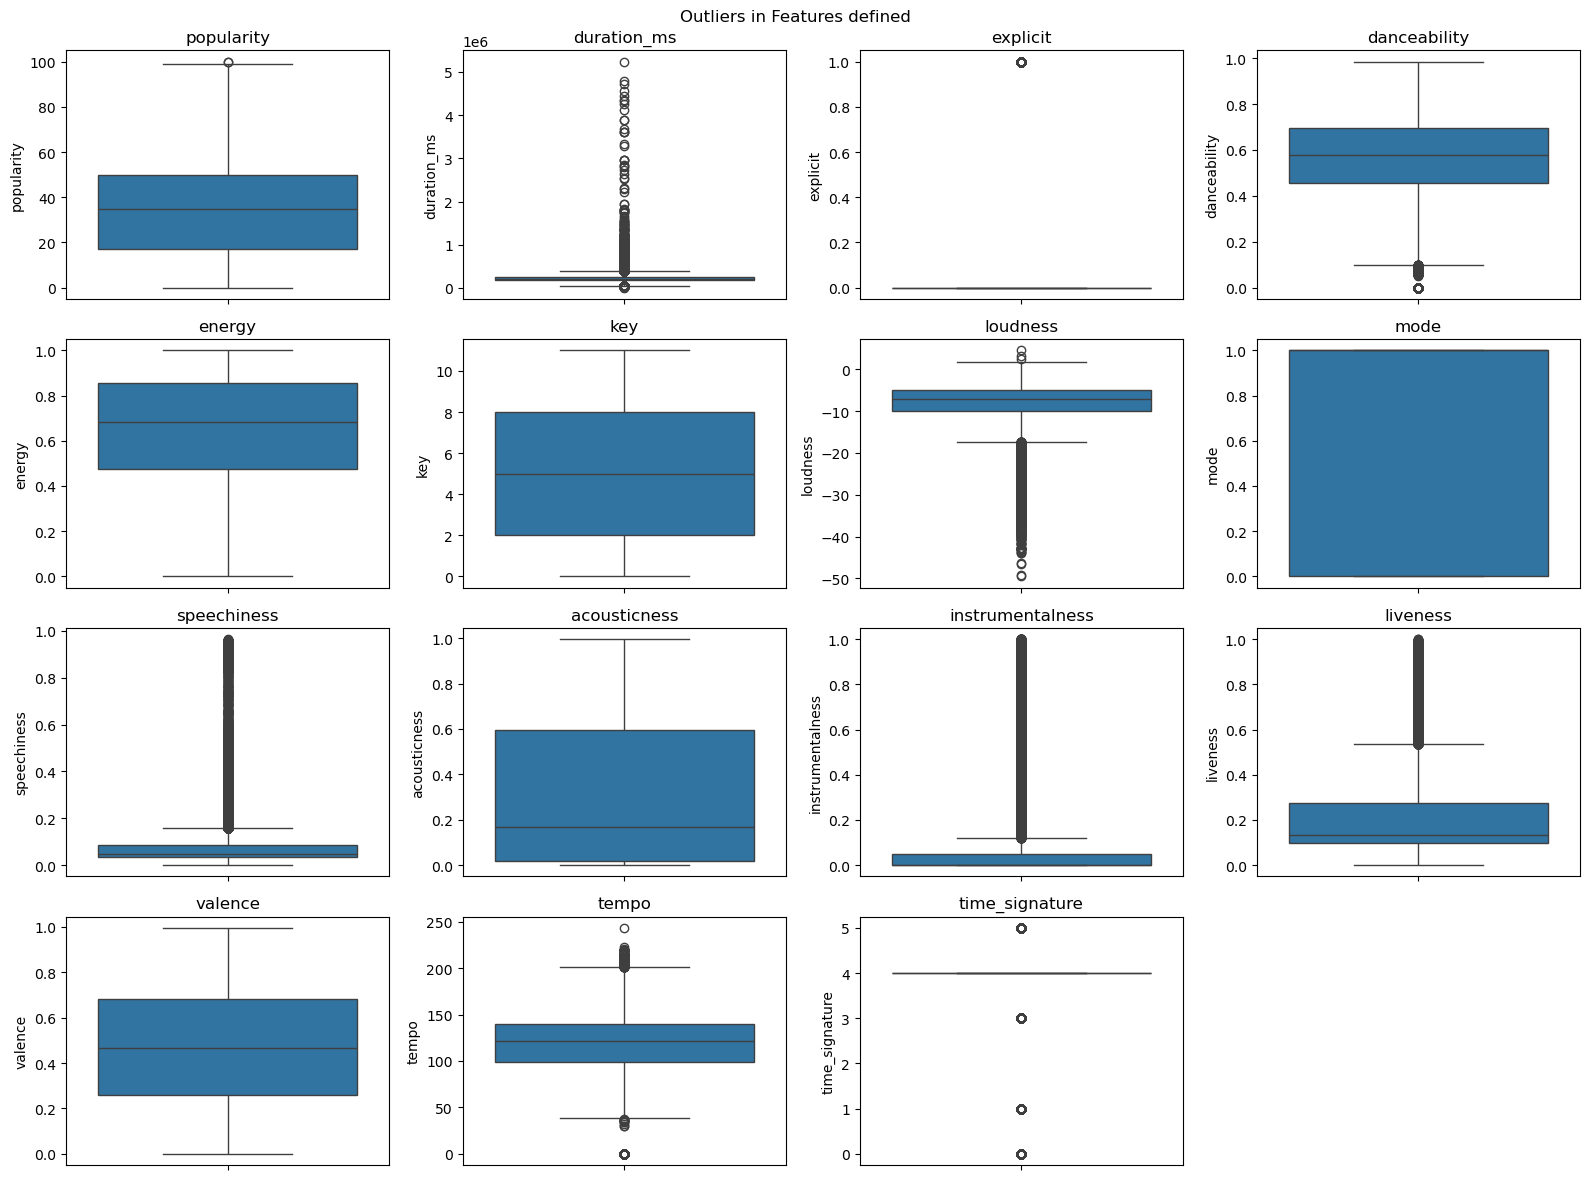

In [15]:
#Variable boxplots before outlier removal (for outlier detection)
plt.figure(figsize = (16,12))
plt.suptitle("Outliers in Features defined")
for i ,col in enumerate(data.columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data = data, y = col)
    plt.title(col)

plt.tight_layout()
plt.show()

The image contains 15 box plots, each representing the distribution of a different audio feature. The features shown include popularity, duration (in milliseconds), explicit content (binary), danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence,	tempo, and time_signature. The plots show the median, quartiles, and outliers for each feature across a dataset of audio tracks. Some features eg popularity, energy, key, and valence exhibit a more concentrated distribution around the median, while others such as speechness, time_signature, liveness, loudness, and duration_ms have a wider spread and notable outliers.

In [16]:
#Outlier removal
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

#Define Z-score outlier removal
def remove_outliers_zscore(data, columns, threshold=3):
    for col in columns:
        z_scores = (data[col] - data[col].mean()) / data[col].std()
        data = data[(np.abs(z_scores) < threshold)]
    return data

#Choose method based on assumed distribution (from earlier analysis)
iqr_columns = ['popularity', 'duration_ms', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
zscore_columns = ['energy', 'valence', 'tempo', 'loudness']

#Apply IQR
cleaned_data = remove_outliers_iqr(data, iqr_columns)

#Apply Z-score
cleaned_data = remove_outliers_zscore(cleaned_data, zscore_columns)

#Resulting shape compared to original
print("Original shape:", data.shape)
print("Cleaned shape:", cleaned_data.shape)

Original shape: (113549, 15)
Cleaned shape: (68253, 15)


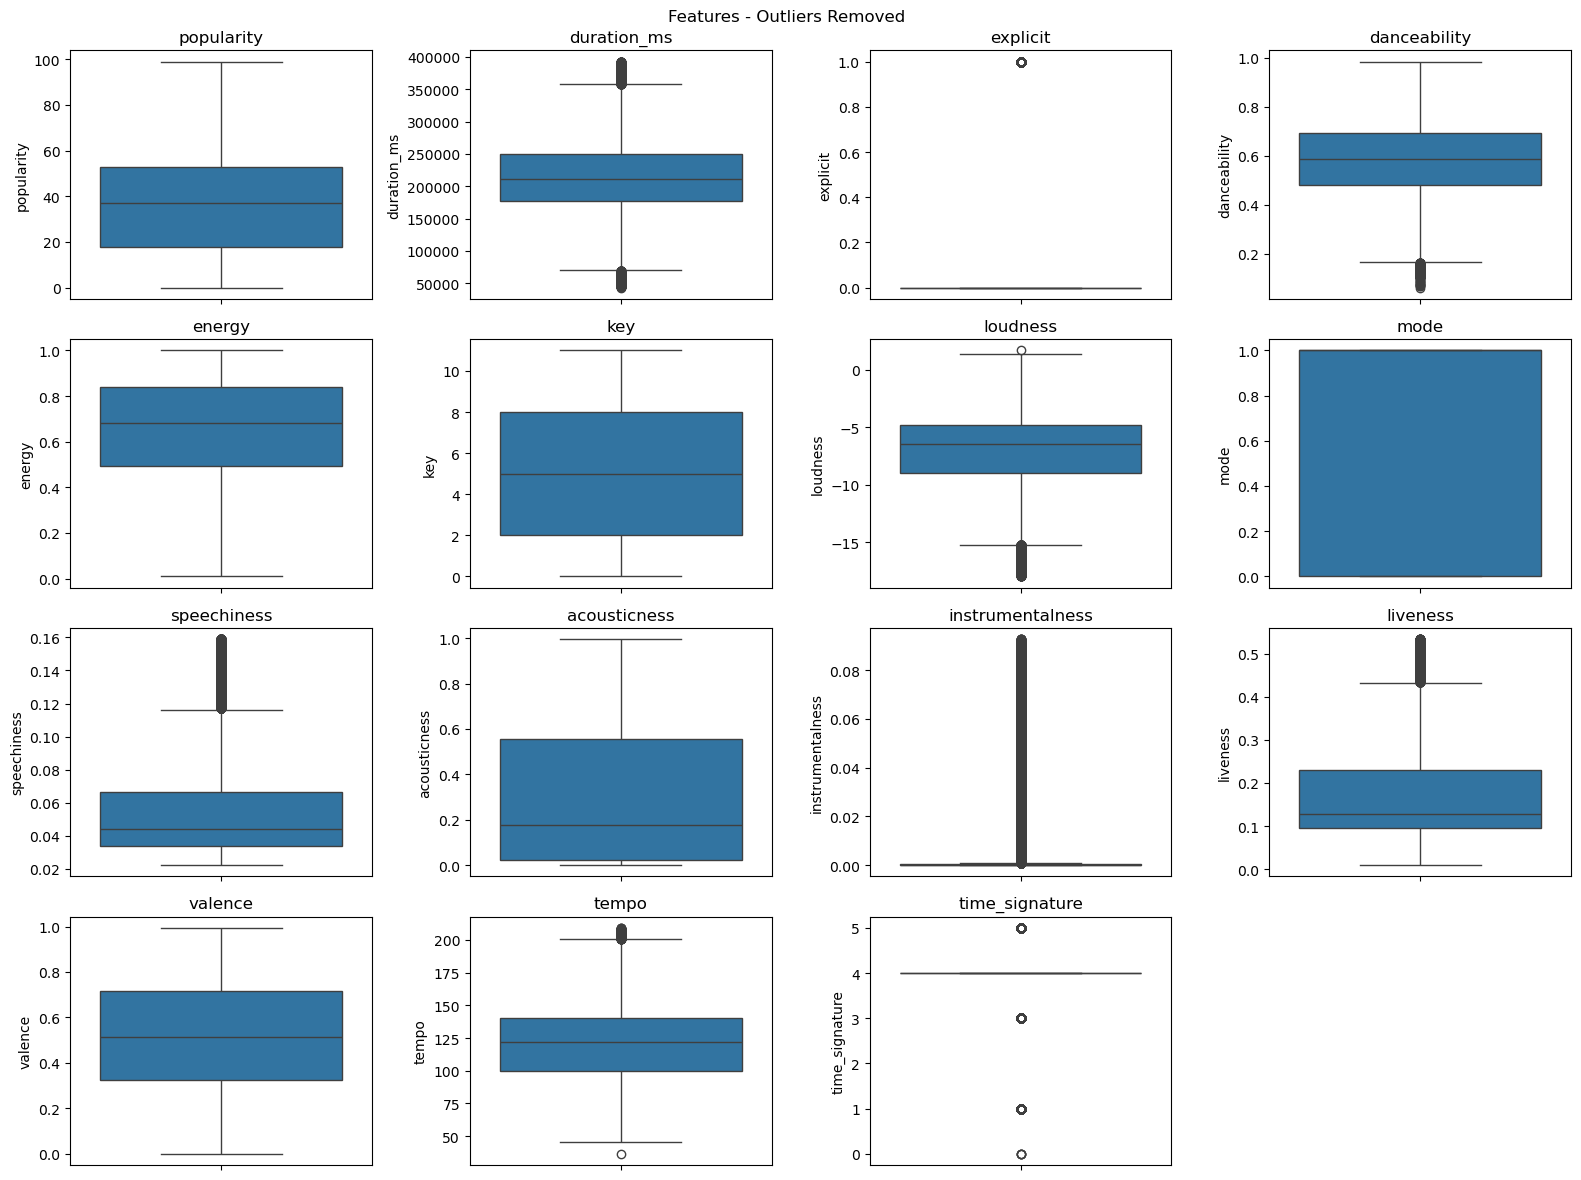

In [17]:
#Variable boxplots after outlier removal
plt.figure(figsize = (16,12))
plt.suptitle("Features - Outliers Removed")
for i ,col in enumerate(cleaned_data.columns):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data = cleaned_data, y = col)
    plt.title(col)

plt.tight_layout()
plt.show()

The boxplot illustrates the distribution of features after outlier removal, with noticeable improvements in features like duration_ms, speechiness, and loudness. Although some outliers remain, the number has significantly decreased, resulting in a dataset that is more realistic, centered, and concentrated around the median, indicating improved data quality and reduced skewness.

In [18]:
cleaned_data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
4,82,198853,False,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4
5,58,214240,False,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4


### Encoding

In [19]:
#Encoding explicit
le = LabelEncoder()
cleaned_data['explicit'] = le.fit_transform(cleaned_data['explicit']) #True = 1, False = 0
cleaned_data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,0,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,0,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
4,82,198853,0,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4
5,58,214240,0,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4


### Scaling

In [20]:
#Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_data)
print(scaled_data)

[[ 1.63226699  0.26226223 -0.27954293 ...  0.79882992 -1.20285217
   0.22173898]
 [ 0.86559493 -1.1768848  -0.27954293 ... -1.03767258 -1.56505732
   0.22173898]
 [ 0.95078072 -0.08999642 -0.27954293 ... -1.64027496 -1.60524444
   0.22173898]
 ...
 [-0.53997051  0.9866651  -0.27954293 ...  0.91361133  0.34145194
   0.22173898]
 [ 0.26929444  1.20730615 -0.27954293 ... -0.43916953  0.46586879
   0.22173898]
 [-0.53997051  0.46040773 -0.27954293 ...  0.77013457 -1.50569707
   0.22173898]]


In [21]:
#Converting the scaled features into a DataFrame
sdata = pd.DataFrame(scaled_data, columns = cleaned_data.columns, index = cleaned_data.index)
sdata.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1.632267,0.262262,-0.279543,0.615297,-0.863488,-1.206345,0.111574,-1.410353,2.950002,-0.872565,-0.297088,1.757860,0.798830,-1.202852,0.221739
1,0.865595,-1.176885,-0.279543,-1.069794,-2.191848,-1.206345,-3.175040,0.709042,0.710780,2.031853,-0.296718,-0.662987,-1.037673,-1.565057,0.221739
2,0.950781,-0.089996,-0.279543,-0.951311,-1.322786,-1.487978,-0.824683,0.709042,0.019206,-0.293505,-0.297170,-0.512273,-1.640275,-1.605244,0.221739
4,2.015603,-0.302577,-0.279543,0.233518,-0.944541,-0.924712,-0.808076,0.709042,-0.084865,0.550007,-0.297170,-0.833483,-1.447606,-0.090256,0.221739
5,0.993374,-0.029381,-0.279543,0.694285,-0.773430,0.201822,-0.534217,0.709042,1.674283,-0.036218,-0.297170,0.165941,0.597962,-0.852040,0.221739


### **2. Dimensionality Reduction (PCA)**

In [22]:
pca = PCA()
pca_data = pca.fit_transform(sdata)

In [23]:
#How each component explain the variance
explained_var = (pca.explained_variance_ratio_)
explained_var

array([0.18645582, 0.10748794, 0.08002991, 0.0771013 , 0.07153777,
       0.06701511, 0.0647293 , 0.06212538, 0.05948837, 0.05711419,
       0.05051599, 0.04838749, 0.03098174, 0.02765589, 0.00937379])

In [24]:
#How many components explain 90–95% of the variance
explained_var1 = np.cumsum(pca.explained_variance_ratio_)
explained_var1

array([0.18645582, 0.29394376, 0.37397367, 0.45107497, 0.52261275,
       0.58962785, 0.65435715, 0.71648254, 0.77597091, 0.8330851 ,
       0.88360109, 0.93198858, 0.96297032, 0.99062621, 1.        ])

In [25]:
#Components that explain between 90 and 95% of the variance
components_90_to_95 = np.argmax((explained_var1 >= 0.90) & (explained_var1 <= 0.95)) + 1

print(f"Number of components to explain 90 to 95% variance: {components_90_to_95}")

Number of components to explain 90 to 95% variance: 12


The first 12 principal components explain 93% (0.90 - 0.95) of the total variance in the dataset. This indicates that we can reduce the dataset’s dimensionality from 15 original features to 12 components with minimal loss of information. This compressed representation retains most of the meaningful patterns and reduces noise or redundancy. This is also explained by the plot below.

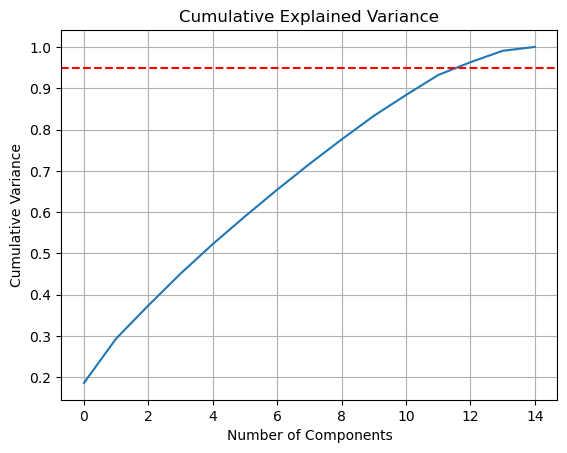

In [26]:
#Explained variance plot
plt.plot(explained_var1)
plt.axhline(0.95, color = 'r', linestyle = '--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

The image displays a line graph showing the cumulative explained variance against the number of components.  The graph plots the increase in explained variance as the number of components used increases. A red dashed horizontal line represents a threshold, likely indicating a desired level of explained variance (around 0.95). The curve approaches this threshold, suggesting that a sufficient number of components are being used to capture most of the variance in the data.  The graph is a visual representation of dimensionality reduction techniques, commonly used in data science and machine learning.

In [27]:
#2D PCA projection
pca_2d = PCA(n_components = 2)
data_2d = pca_2d.fit_transform(sdata)

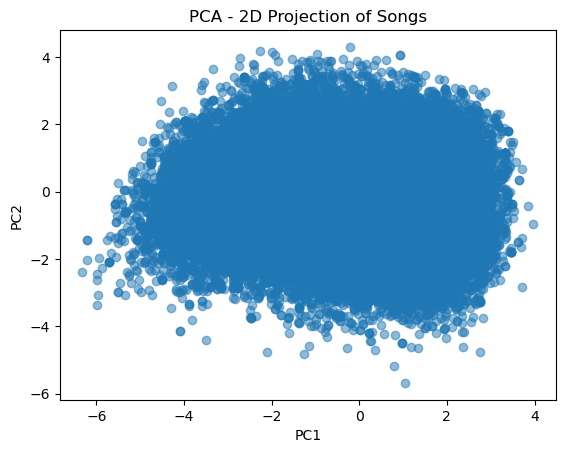

In [28]:
#2D PCA projection scatter
plt.scatter(data_2d[:,0], data_2d[:,1], alpha = 0.5)
plt.title('PCA - 2D Projection of Songs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The PCA plot maps all Spotify tracks onto the first two principal components, capturing most of the variability in key musical features like tempo, energy, valence, and acousticness. The wide distribution of data points reflects the variety of musical styles present, while denser regions point to inherent groupings of tracks with similar audio characteristics. This demonstrates that PCA is a powerful tool for visualizing complex datasets and provides a solid foundation for subsequent clustering techniques such as K-Means.

### **3. K-Means Clustering**

In [29]:
#Elbow Method
inertia = []
sil_scores = []

k_values = range(2,11)

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_2d)
    labels = kmeans.labels_

    sil_scores_a = silhouette_score(data_2d, labels)
    sil_scores.append(silhouette_score(data_2d, labels))

    inertia_a = kmeans.inertia_
    inertia.append(kmeans.inertia_)

    print(f"\033[1mFitting KMeans for k = {k}\033[0m: Silhoute Score = {sil_scores[-1]:.2f} while Inertia = {inertia[-1]:.2f}")

Fitting KMeans for k = 2: Silhoute Score = 0.41 while Inertia = 167213.10
Fitting KMeans for k = 3: Silhoute Score = 0.38 while Inertia = 113796.38
Fitting KMeans for k = 4: Silhoute Score = 0.35 while Inertia = 93112.27
Fitting KMeans for k = 5: Silhoute Score = 0.35 while Inertia = 73165.24
Fitting KMeans for k = 6: Silhoute Score = 0.32 while Inertia = 63903.98
Fitting KMeans for k = 7: Silhoute Score = 0.32 while Inertia = 55414.41
Fitting KMeans for k = 8: Silhoute Score = 0.33 while Inertia = 49277.40
Fitting KMeans for k = 9: Silhoute Score = 0.31 while Inertia = 44896.41
Fitting KMeans for k = 10: Silhoute Score = 0.32 while Inertia = 39995.81


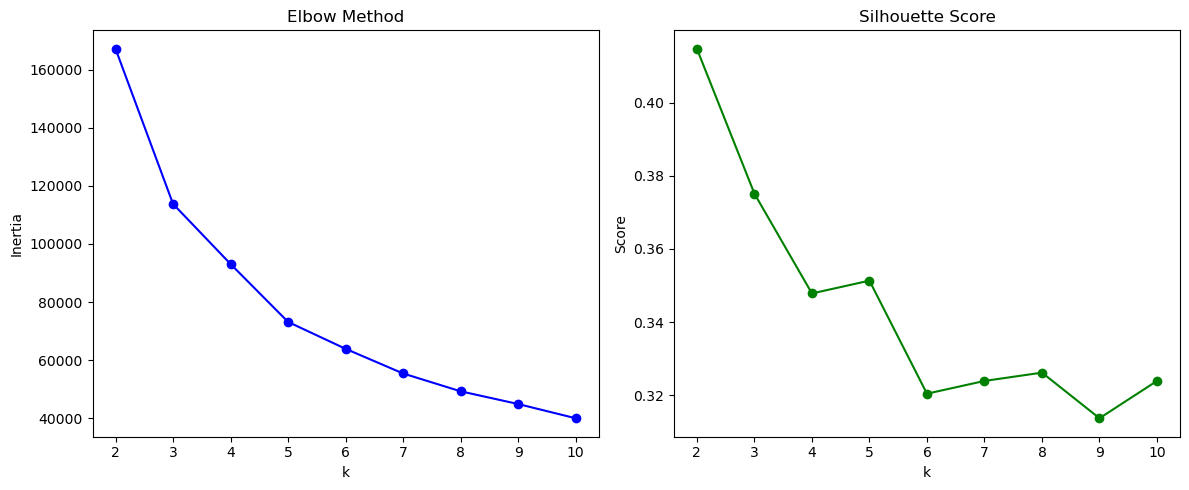

In [30]:
#Plotting
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

The Elbow plot shows a sharp drop in inertia up to k = 3, after which the curve flattens, suggesting 3 as an optimal point where adding more clusters yields minimal improvement. Meanwhile, the Silhouette Score plot peaks at k = 2, indicating the best cluster cohesion and separation at that point. While k = 2 offers the most distinct clustering, k = 3 provides a good balance between compactness and model complexity. Depending on the analytical goal, either can be justified as optimal.

In [31]:
#Apply K-Means using optimal k
k_opt = 3
kmeans = KMeans(n_clusters = k_opt, random_state = 42)
clusters_kmeans = kmeans.fit_predict(data_2d)

In [32]:
#Evaluation
sil_k = silhouette_score(data_2d, clusters_kmeans)
db_k = davies_bouldin_score(data_2d, clusters_kmeans)

In [33]:
print("Silhouette Score (KMeans):", sil_k)
print("Davies-Bouldin Index (KMeans):", db_k)

Silhouette Score (KMeans): 0.3751175620665227
Davies-Bouldin Index (KMeans): 0.903616379435921


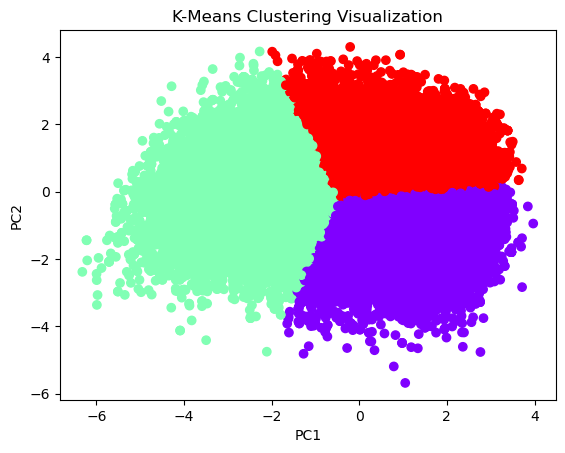

In [34]:
# Visualize in PCA space
plt.scatter(data_2d[:, 0], data_2d[:, 1], c = clusters_kmeans, cmap = 'rainbow')
plt.title("K-Means Clustering Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### **4. Hierarchical Clustering**

In [35]:
#Sample subset for clustering
sampled_data = resample(data_2d, n_samples=1000, random_state=42)

#Applying Agglomerative Clustering with Ward linkage and Euclidean distance
agglo = AgglomerativeClustering(n_clusters = (k_opt), linkage = 'ward')
clusters_agglo = agglo.fit_predict(sampled_data)

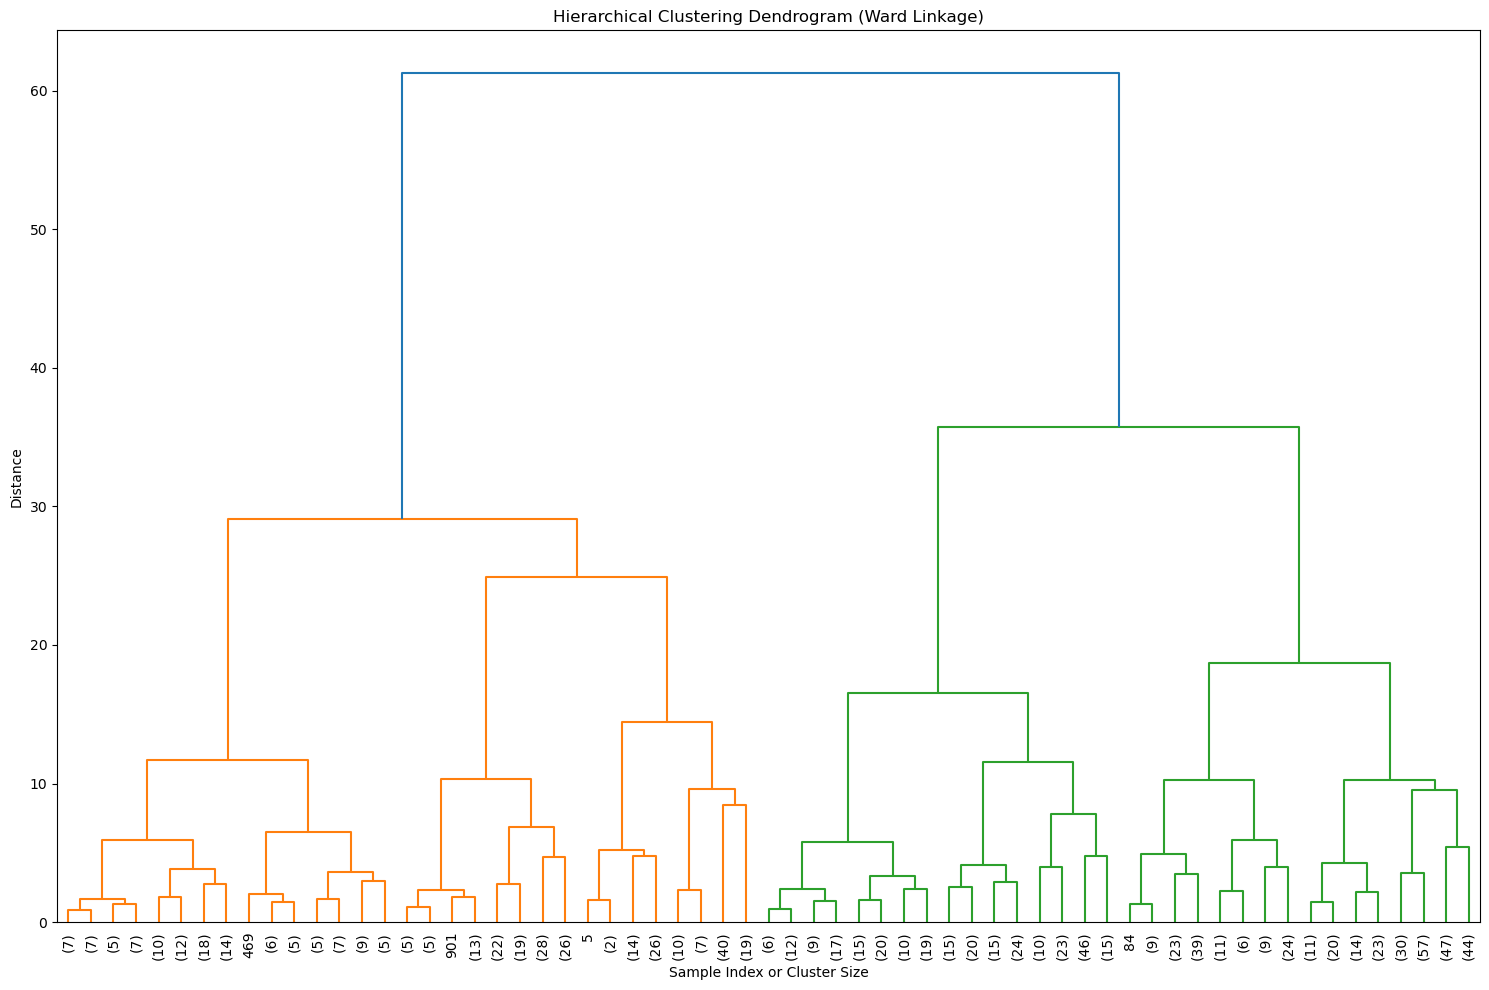

In [36]:
# Perform hierarchical clustering (linkage matrix)
Z = linkage(sampled_data, method = 'ward')

# Plot the dendrogram
plt.figure(figsize = (15, 10))
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
dendrogram(Z, truncate_mode = 'level', p = 5)
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.xticks(fontsize = 10)
plt.tight_layout()
plt.show()

In [37]:
#Evaluation
sil_h = silhouette_score(sampled_data, clusters_agglo)
db_h = davies_bouldin_score(sampled_data, clusters_agglo)

In [38]:
print("Silhouette Score (Hierarchical):", sil_h)
print("Davies-Bouldin Index (Hierarchical):", db_h)

Silhouette Score (Hierarchical): 0.31289355887567827
Davies-Bouldin Index (Hierarchical): 0.9632115561823248


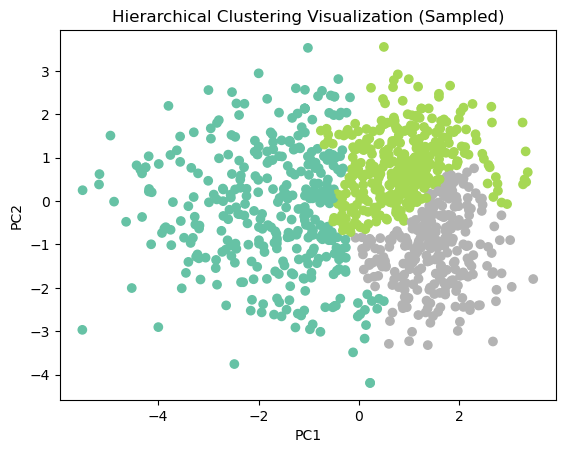

In [39]:
#Re-sample PCA data the same way

#Visualize just the sample
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], c = clusters_agglo, cmap = 'Set2')
plt.title("Hierarchical Clustering Visualization (Sampled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### **5. Model Validation**

In [40]:
#Apply clustering
hc = AgglomerativeClustering(n_clusters = (k_opt))
clusters_hc = hc.fit_predict(sampled_data)

In [41]:
#Evaluating Silhouette Score and Davies-Bouldin Index
db_h = davies_bouldin_score(sampled_data, clusters_hc)
sil_h = silhouette_score(sampled_data, clusters_hc)

In [42]:
print("Davies-Bouldin Index (Hierarchical):", db_h)
print("Silhouette Score (Hierarchical):", sil_h)

Davies-Bouldin Index (Hierarchical): 0.9632115561823248
Silhouette Score (Hierarchical): 0.31289355887567827


In [43]:
k_values = [k_opt - 1, k_opt, k_opt + 1, k_opt + 2]
sil_scores = []
dbi_scores = []

# Evaluate each k
for k in k_values:
    print(f"Evaluating k = {k}")
    
    # Optional PCA for visualization consistency (keep original data if needed)
    pca = PCA(n_components = 2, random_state = 42)
    reduced_data = pca.fit_transform(sampled_data)

    # Linkage and clustering
    Z = linkage(reduced_data, method = 'ward')
    clusters = fcluster(Z, t = k, criterion = 'maxclust')

    # Evaluate metrics
    sil = silhouette_score(sampled_data, clusters)
    dbi = davies_bouldin_score(sampled_data, clusters)

    sil_scores.append(sil)
    dbi_scores.append(dbi)

    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Davies-Bouldin Index: {dbi:.4f}\n")

Evaluating k = 2
  Silhouette Score: 0.3959
  Davies-Bouldin Index: 1.0453

Evaluating k = 3
  Silhouette Score: 0.3129
  Davies-Bouldin Index: 0.9632

Evaluating k = 4
  Silhouette Score: 0.2996
  Davies-Bouldin Index: 1.0274

Evaluating k = 5
  Silhouette Score: 0.2974
  Davies-Bouldin Index: 0.9445



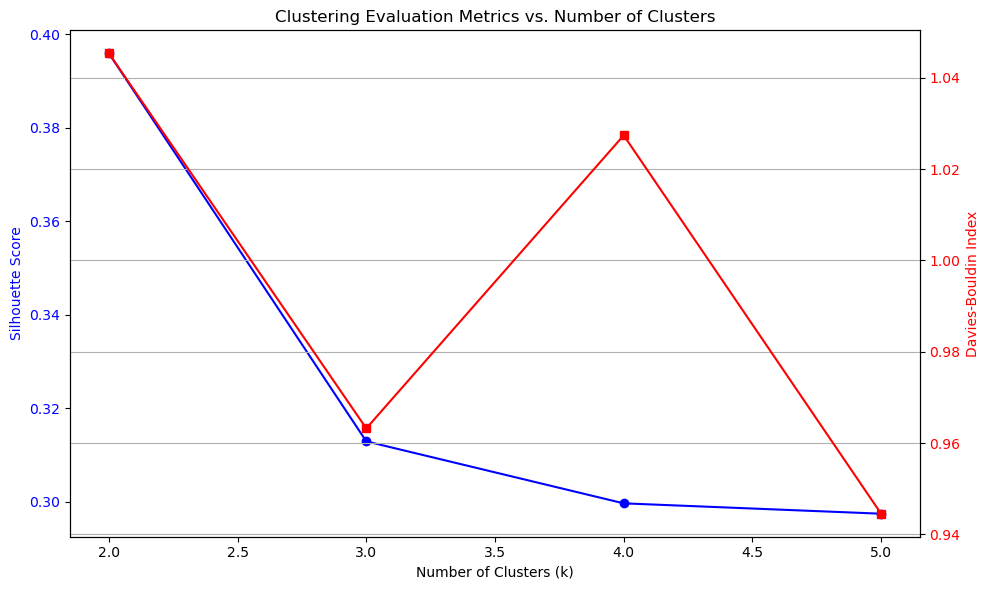

In [44]:
# Plotting
fig, ax1 = plt.subplots(figsize = (10, 6))

#Silhouette Score plot
ax1.set_title("Clustering Evaluation Metrics vs. Number of Clusters")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Silhouette Score", color = "blue")
ax1.plot(k_values, sil_scores, marker = 'o', color = "blue", label = "Silhouette Score")
ax1.tick_params(axis = 'y', labelcolor = "blue")

#Davies-Bouldin plot on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Davies-Bouldin Index", color = "red")
ax2.plot(k_values, dbi_scores, marker = 's', color = "red", label = "Davies-Bouldin Index")
ax2.tick_params(axis = 'y', labelcolor = "red")

# Grid and legend
fig.tight_layout()
plt.grid(True)
plt.show()

### **6. Label Clusters & Recommend Songs**

In [45]:
#Add cluster back to original data
sdata['cluster'] = clusters_kmeans

In [46]:
#Manual labeling (example)
cluster_labels = {
    0: "Chill Vibes",
    1: "High Energy Dance",
    2: "Acoustic Mellow"
}

In [47]:
sdata['cluster_name'] = sdata['cluster'].map(cluster_labels)

In [48]:
sdata.drop('cluster', axis = 1, inplace = True)
sdata.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster_name
0,1.632267,0.262262,-0.279543,0.615297,-0.863488,-1.206345,0.111574,-1.410353,2.950002,-0.872565,-0.297088,1.757860,0.798830,-1.202852,0.221739,Acoustic Mellow
1,0.865595,-1.176885,-0.279543,-1.069794,-2.191848,-1.206345,-3.175040,0.709042,0.710780,2.031853,-0.296718,-0.662987,-1.037673,-1.565057,0.221739,High Energy Dance
2,0.950781,-0.089996,-0.279543,-0.951311,-1.322786,-1.487978,-0.824683,0.709042,0.019206,-0.293505,-0.297170,-0.512273,-1.640275,-1.605244,0.221739,High Energy Dance
4,2.015603,-0.302577,-0.279543,0.233518,-0.944541,-0.924712,-0.808076,0.709042,-0.084865,0.550007,-0.297170,-0.833483,-1.447606,-0.090256,0.221739,High Energy Dance
5,0.993374,-0.029381,-0.279543,0.694285,-0.773430,0.201822,-0.534217,0.709042,1.674283,-0.036218,-0.297170,0.165941,0.597962,-0.852040,0.221739,Acoustic Mellow


In [49]:
#Recommend 3 songs per cluster
for cl in sdata['cluster_name'].unique():
    print(f"\n{cl} Playlist:")
    for i, row in sdata[sdata['cluster_name'] == cl].sample(3).iterrows():
        print(f"🎧 Track {i} | Popularity: {row['popularity']} | Energy: {row['energy']}")


Acoustic Mellow Playlist:
🎧 Track 84922 | Popularity: 0.7804091466790214 | Energy: -0.7374066242103048
🎧 Track 8544 | Popularity: 0.14151576285852327 | Energy: -0.5437812574465163
🎧 Track 23681 | Popularity: 0.6100375776602218 | Energy: 0.8836429579981555

High Energy Dance Playlist:
🎧 Track 69737 | Popularity: -0.5399705132166747 | Energy: -2.0072287969402653
🎧 Track 14293 | Popularity: -1.4770141428200718 | Energy: -0.9850669770477084
🎧 Track 12355 | Popularity: -0.28441315968847547 | Energy: -0.9220261599618238

Chill Vibes Playlist:
🎧 Track 72887 | Popularity: -0.3695989441978752 | Energy: 1.4194899032281743
🎧 Track 28664 | Popularity: 0.3544802241320226 | Energy: 0.45586598491536745
🎧 Track 28871 | Popularity: 0.14151576285852327 | Energy: 0.47838056244604055


### **7. Predict Cluster for New Song**

In [50]:
def predict_song_cluster(song_features, model = kmeans, scaler = scaler, pca_model = pca_2d):
    features_scaled = scaler.transform([song_features])
    features_pca = pca_model.transform(features_scaled)
    cluster = model.predict(features_pca)[0]
    return cluster_labels[cluster]

In [51]:
#Example
predict_song_cluster([1.9, -0.7, -0.3, -0.8, -1.9, -1.2, -1.8, 0.8, -0.1, 1.8, -0.5, -0.6, -0.8, -1.5, 0.2])

'High Energy Dance'

In [52]:
import joblib

#Saving the trained model
joblib.dump(kmeans, 'kmeans_cluster_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca_2d, 'pca.pkl')

['pca.pkl']